In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from dataHandler import load_split_train_data, load_data, dataAugment, CLASS_NUM
from model import getModel
import shutil
import os


In [3]:
# clear all the previous imgs outputs
shutil.rmtree('./ret_img')
os.mkdir('./ret_img')

# loading the data
print('Loading data...')
dataset = load_split_train_data()
test_imgs, test_labels = load_data(type='TEST')
print('Data loaded.')
print(len(dataset), dataset[0][0].shape, dataset[0][1].shape)


Loading data...
Data loaded.
5 (10000, 32, 32, 3) (10000, 10)


In [4]:
KERNEL_SIZE = 3
BATCH_SIZE = 64
EPOCH = 2
ROUND = 2
USER_NUM = 5

users_acc = [[]]*USER_NUM
users_val_acc = [[]]*USER_NUM
users_loss = [[]]*USER_NUM
users_val_loss = [[]]*USER_NUM

overall_val_acc = []*ROUND
overall_val_loss = []*ROUND

model = getModel(test_imgs.shape[1:], KERNEL_SIZE, CLASS_NUM)

model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        1792      
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 64)       256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        36928     
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 64)       0         
 )                                                               
                                                        

In [5]:
def split_train(model, dataset, test_imgs, test_labels):
    weights = model.get_weights()

    new_weights = []
    for batchIdx in range(0, len(dataset)):
        print('\n')
        print('================User' + str(batchIdx + 1) + '=================')

        train_imgs = dataset[batchIdx][0]
        train_labels = dataset[batchIdx][1]

        gen = dataAugment(train_imgs, train_labels, batch_size=BATCH_SIZE)

        model.set_weights(weights)

        h = model.fit(x=gen,  epochs=EPOCH, steps_per_epoch=train_imgs.shape[0] // BATCH_SIZE,
                      validation_data=(test_imgs, test_labels))

        acc = h.history['accuracy']
        loss = h.history['loss']
        val_acc = h.history['val_accuracy']
        val_loss = h.history['val_loss']

        users_acc[batchIdx] += (acc)
        users_val_acc[batchIdx] += (val_acc)
        users_loss[batchIdx] += (loss)
        users_val_loss[batchIdx] += (val_loss)

        new_weights.append(model.get_weights())

    return new_weights


In [6]:
def fedAvg(model, new_weights=[]):
    sum_weights = 0

    for i in range(0, len(new_weights)):
        sum_weights += np.array(new_weights[i], dtype=object)

    mean_weights = sum_weights / len(new_weights)

    model.set_weights(mean_weights.tolist())
    return model



================Round1=================


================User1=================
Epoch 1/2


2021-12-20 21:23:56.221185: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2021-12-20 21:23:56.222431: W tensorflow/stream_executor/gpu/asm_compiler.cc:230] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.6
2021-12-20 21:23:56.222454: W tensorflow/stream_executor/gpu/asm_compiler.cc:233] Used ptxas at ptxas
2021-12-20 21:23:56.222567: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


156/156 [==============================] - 12s 45ms/step - loss: 3.8365 - accuracy: 0.2428 - val_loss: 3.2216 - val_accuracy: 0.1687
Epoch 2/2
156/156 [==============================] - 5s 35ms/step - loss: 2.4115 - accuracy: 0.3088 - val_loss: 2.2332 - val_accuracy: 0.3573


================User2=================
Epoch 1/2
156/156 [==============================] - 5s 35ms/step - loss: 3.8699 - accuracy: 0.2075 - val_loss: 3.1496 - val_accuracy: 0.1688
Epoch 2/2
156/156 [==============================] - 5s 34ms/step - loss: 2.3549 - accuracy: 0.2937 - val_loss: 1.9878 - val_accuracy: 0.3781


================User3=================
Epoch 1/2
156/156 [==============================] - 6s 36ms/step - loss: 3.8457 - accuracy: 0.2006 - val_loss: 3.0351 - val_accuracy: 0.1869
Epoch 2/2
156/156 [==============================] - 5s 35ms/step - loss: 2.3921 - accuracy: 0.2711 - val_loss: 2.1166 - val_accuracy: 0.3245


================User4=================
Epoch 1/2
156/156 [===============

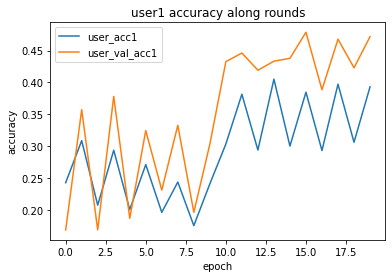

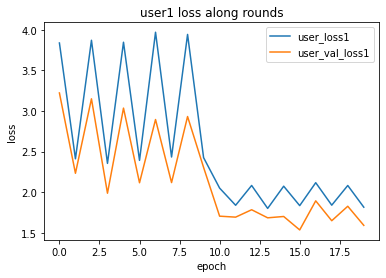

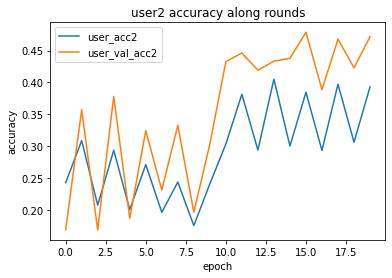

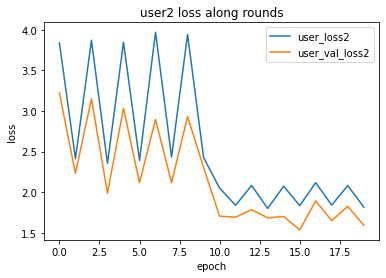

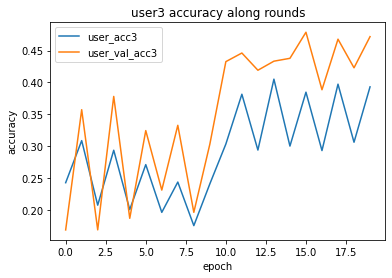

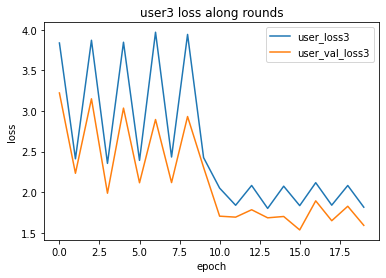

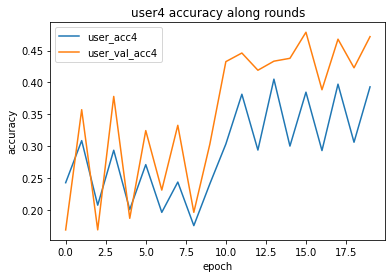

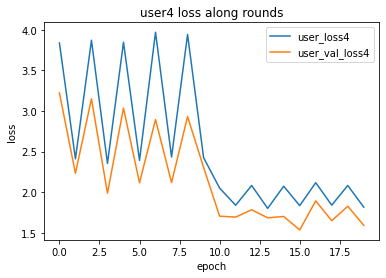

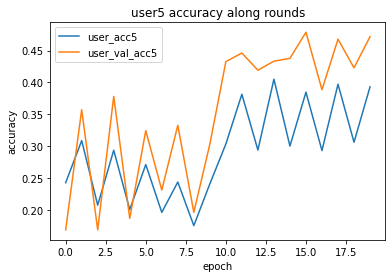

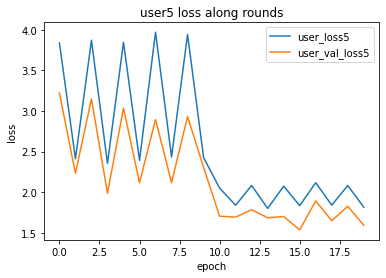

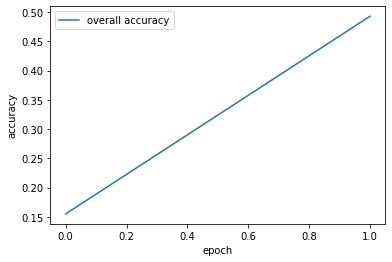

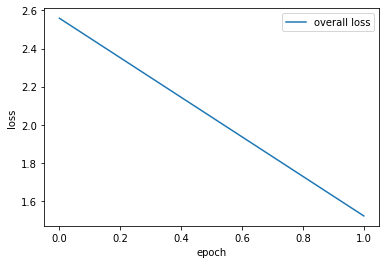

In [7]:
def fl():
    avg_model = model

    for i in range(0, ROUND):
        print('\n')
        print('================Round' + str(i + 1) + '=================')

        new_weights = split_train(avg_model, dataset, test_imgs, test_labels)
        avg_model = fedAvg(model, new_weights)

        print('Evaluation')
        loss, acc = avg_model.evaluate(test_imgs, test_labels)

        overall_val_acc.append(acc)
        overall_val_loss.append(loss)


    for user in range(0, USER_NUM):
        plt.figure()
        plt.title("user" + str(user + 1) + " accuracy along rounds")
        plt.plot(users_acc[user], label='user_acc' + str(user + 1))
        plt.plot(users_val_acc[user], label='user_val_acc' + str(user + 1))
        plt.xlabel('epoch')
        plt.ylabel('accuracy')
        plt.legend()
        plt.savefig('./ret_img/user' + str(user + 1) + '_acc.png')

        plt.figure()
        plt.title("user" + str(user + 1) + " loss along rounds")
        plt.plot(users_loss[user], label='user_loss' + str(user + 1))
        plt.plot(users_val_loss[user], label='user_val_loss' + str(user + 1))
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.legend()
        plt.savefig('./ret_img/user' + str(user + 1) + '_loss.png')

    plt.figure()
    plt.plot(overall_val_acc, label='overall accuracy')
    plt.xlabel('round')
    plt.ylabel('accuracy')
    plt.legend()
    plt.savefig('./ret_img/overall_acc.png')

    plt.figure()
    plt.plot(overall_val_loss, label='overall loss')
    plt.xlabel('round')
    plt.ylabel('loss')
    plt.legend()
    plt.savefig('./ret_img/overall_loss.png')

fl()
plt.show()
